In [1209]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from sklearn import preprocessing
import importlib
import community
import seaborn as sns
importlib.reload(fs)

<module 'feature_selection' from 'C:\\Users\\faisal\\PycharmProjects\\linkPrediction\\feature_selection.py'>

In [503]:
filepath=['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv']
graphpath='C:/Users/faisal/PycharmProjects/linkPrediction/graphs'
df, key_list = ut.load_dataset(filepath)

In [1128]:
nodes={}
ts=1993
te=2003
it_index=1

#dynamic graph build and save
#nodes intersection between train and test
nodes=gr.nodes_intersection(df, key_list, ts, te, te+2)
print(len(nodes))
#dynamic train graph build
for t in range(ts,te,it_index):
    g=nx.Graph()
    train_graph = gr.build_graph(g, df, key_list, nodes, t, t+1)
    file="train_graph_"+str(t)
    file_name = os.path.join(graphpath, file+".gpickle")
    gr.save_graph(train_graph, file_name)
    print(file_name+" saved,","nodes:",len(train_graph.nodes()),"edges:",len(train_graph.edges()))

#test graph build and save
g=nx.Graph()
test_graph = gr.build_graph(g, df, key_list, nodes, te, te+2)
file="test_graph_"+str(te)+"-"+str(te+2)
file_name = os.path.join(graphpath, file+".gpickle")
gr.save_graph(test_graph, file_name)
print(file_name+" saved,","nodes:",len(test_graph.nodes()),"edges:",len(test_graph.edges()))

665
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1993.gpickle saved, nodes: 102 edges: 135
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1994.gpickle saved, nodes: 123 edges: 107
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1995.gpickle saved, nodes: 181 edges: 253
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1996.gpickle saved, nodes: 200 edges: 287
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1997.gpickle saved, nodes: 190 edges: 219
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1998.gpickle saved, nodes: 200 edges: 269
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1999.gpickle saved, nodes: 218 edges: 234
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2000.gpickle saved, nodes: 255 edges: 409
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2001.gpickle saved, nodes: 281 edges: 446
C:/Users/faisal/PycharmP

In [1129]:
#static graph build and save
ts=1980
te=1993
#parent graph buile and save
g=nx.Graph()
parent_graph = gr.build_graph(g, df, key_list, nodes, ts, te)
file="parent_graph_"+str(ts)+"-"+str(te)
file_name = os.path.join(graphpath, file+".gpickle")
gr.save_graph(parent_graph, file_name)
print(file_name+" saved,","nodes:",len(parent_graph.nodes()),"edges:",len(parent_graph.edges()))
#static train graph buile and save
ts=1993
te=2003
g=nx.Graph()
train_graph_static = gr.build_graph(g, df, key_list, nodes, ts, te)
file="train_graph_"+str(ts)+"-"+str(te)
file_name = os.path.join(graphpath, file+".gpickle")
gr.save_graph(train_graph_static, file_name)
print(file_name+" saved,","nodes:",len(train_graph_static.nodes()),"edges:",len(train_graph_static.edges()))

C:/Users/faisal/PycharmProjects/linkPrediction/graphs\parent_graph_1980-1993.gpickle saved, nodes: 199 edges: 292
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1993-2003.gpickle saved, nodes: 665 edges: 2171


In [1130]:
#load graph
#dynamic train graph
g_train={}
ts=1993
te=2003
it_index=1
for t in range(ts,te,it_index):
    file="train_graph_"+str(t)
    file_name = os.path.join(graphpath, file+".gpickle")
    g_train[t]=gr.load_graph(file_name)
    print(file_name+" loaded,","nodes:",len(g_train[t].nodes()),"edges:",len(g_train[t].edges()))
#test graph
file="test_graph_"+str(te)+"-"+str(te+2)
file_name = os.path.join(graphpath, file+".gpickle")
g_test=gr.load_graph(file_name)
print(file_name+" loaded,","nodes:",len(g_test.nodes()),"edges:",len(g_test.edges()))
#parent graph
ts=1980
te=1993
file="parent_graph_"+str(ts)+"-"+str(te)
file_name = os.path.join(graphpath, file+".gpickle")
g_parent=gr.load_graph(file_name)
print(file_name+" loaded,","nodes:",len(g_parent.nodes()),"edges:",len(g_parent.edges()))
#static train graph
ts=1993
te=2003
file="train_graph_"+str(ts)+"-"+str(te)
file_name = os.path.join(graphpath, file+".gpickle")
g_train_static=gr.load_graph(file_name)
print(file_name+" loaded,","nodes:",len(g_train_static.nodes()),"edges:",len(g_train_static.edges()))

C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1993.gpickle loaded, nodes: 102 edges: 135
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1994.gpickle loaded, nodes: 123 edges: 107
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1995.gpickle loaded, nodes: 181 edges: 253
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1996.gpickle loaded, nodes: 200 edges: 287
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1997.gpickle loaded, nodes: 190 edges: 219
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1998.gpickle loaded, nodes: 200 edges: 269
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1999.gpickle loaded, nodes: 218 edges: 234
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2000.gpickle loaded, nodes: 255 edges: 409
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2001.gpickle loaded, nodes: 281 edges: 446
C:/Users/faisal/Pyc

In [1433]:
#build dataset for feature
train_data={}
ts=1993
te=2003
it_index=1
for t in range(ts,te,it_index):
    train_data[t] = cl.classification_train_data(g_train[t],g_test)
    cl.print_attributes(train_data[t],'train')
test_data = cl.classification_test_data(g_test)
cl.print_attributes(test_data,'test')

positive train: 120 negative train: 4896 train_size: 5016
positive train: 162 negative train: 7234 train_size: 7396
positive train: 249 negative train: 15788 train_size: 16037
positive train: 310 negative train: 19303 train_size: 19613
positive train: 287 negative train: 17449 train_size: 17736
positive train: 319 negative train: 19312 train_size: 19631
positive train: 346 negative train: 23073 train_size: 23419
positive train: 359 negative train: 31617 train_size: 31976
positive train: 394 negative train: 38500 train_size: 38894
positive train: 400 negative train: 47305 train_size: 47705
test_size: 1246


In [1424]:
#build parent and static train dataset
parent_data = cl.classification_train_data(g_parent,g_test)
cl.print_attributes(parent_data,'train')
train_data_static = cl.classification_train_data(g_train_static,g_test)
cl.print_attributes(train_data_static,'train')
#parent node feature
parent_node_feature = fs.build_feature_set(df, key_list, g_parent, ts, te)
#train node feature
train_node_feature_static = fs.build_feature_set(df, key_list, g_train_static, 1993, 2003)

positive train: 286 negative train: 19123 train_size: 19409
positive train: 820 negative train: 217789 train_size: 218609
1026
6440


3.8126950141709295 6.129084679815224


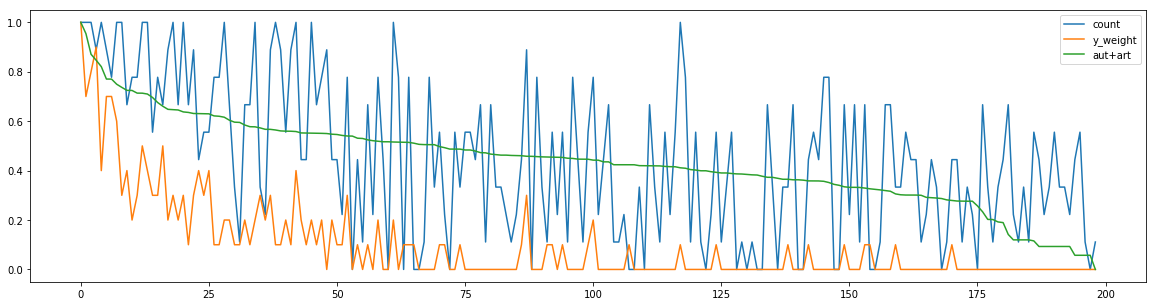

In [1425]:
parent_node_feature['aut+art'] = parent_node_feature.apply(lambda row: 0.7*row['term_art']+row['term_aut'], axis=1)
ts=1993
te=2003
it_index=1
parent_node_feature['count']=0
c=[]
for t in range(ts,te,it_index):
    parent_node_feature['count'] = parent_node_feature.apply(lambda row: row['count']+1
                                                            if row['node_index'] in set(g_train[t].nodes()) 
                                                             else row['count'], axis=1)
parent_node_feature['aut+art']=ut.min_max_norm(parent_node_feature['aut+art'])
parent_node_feature['count']=ut.min_max_norm(parent_node_feature['count'])
parent_node_feature['y_weight']=ut.min_max_norm(parent_node_feature['y_weight'])

a = np.linalg.norm(parent_node_feature['aut+art']-parent_node_feature['count'])
b = np.linalg.norm(parent_node_feature['y_weight']-parent_node_feature['count'])
print(a,b)

parent_1st = parent_node_feature.sort_values('aut+art', ascending=False)
parent_1st = parent_1st[0:200]
parent_1st = parent_1st.reset_index()
parent_1st.plot(y=["count","y_weight", "aut+art"],figsize=(20, 5))

In [1422]:
#pruned train data
pr_train = static_train[1990][(((static_train[1990]['y_weight']>4) & (static_train[1990]['label']==0))|
                               ((static_train[1990]['y_weight']>0) & (static_train[1990]['label']==1)))]
print(len(pr_train[(pr_train['label']==1)]),len(pr_train[(pr_train['label']==0)]))

65 589


In [257]:
pref = nx.preferential_attachment(g_train[1993],list(train_data[1993]['row_name']))
pref = list(pref)
train_data[1993]['pref']=np.array(pref)[:,2]

array([5, 1, 4, ..., 0, 0, 0], dtype=int64)

In [7]:
l1=len(train_data[1993][((train_data[1993]['pref']>0) & (train_data[1993]['label']==0))])
l2=len(train_data[1993][((train_data[1993]['pref']>0) & (train_data[1993]['label']==1))])
print(l1,l2)

426 13


In [147]:
#title analysis
for i,j in train_data[1991].iterrows():
    node1=gr.node_label_find(key_list,j[0][0])
    node2=gr.node_label_find(key_list,j[0][1])
#     if (j[1]==0):
#         print(node1,'+',node2,"------------------")
#         print(g_train[1991].nodes[j[0][0]]['title'])
#         print('--------------------')
#         print(g_train[1991].nodes[j[0][1]]['title'])
#         print('\n')

In [1426]:
ts=1993
te=2003
it_index=1
partition = {}
d_c={}
for t in range(ts,te,it_index):
    partition[t] = community.best_partition(g_train[t])
    G_main_com = g_train[t].copy()
    d_c[t]={}
    for com in set(partition[t].values()) :
        list_nodes = [node for node in partition[t].keys() if partition[t][node] == com]
        H = G_main_com.subgraph(list_nodes)
        d_c[t][com] = nx.degree_centrality(H)

In [1427]:
ts=1993
te=2003
it_index=1
parent_1st_total = set(parent_1st['node_index'])
parent_1st_set = set(parent_1st['node_index'][0:10])
parent_2nd =set()
p_len=[]

p1={}
p2={}
ch={}
gst={}
p1[1993]=parent_1st_set.intersection(set(g_train[1993].nodes()))
p2[1993]=set()
ch[1993]=set()
gst[1993]=set()
for t in range(ts,te,it_index):
    for p in p1[t]:
        nb1 = set(nx.all_neighbors(g_train[t],p))
        p2[t].update(nb1)
        for nbs in nb1:
            nb2 = set(nx.all_neighbors(g_train[t],nbs))
            ch[t].update(nb2)
    p2[t]=p2[t].difference(p1[t])
    ch[t]=ch[t].difference(p1[t],p2[t])
    gst[t]=set(g_train[t].nodes()).difference(p1[t],p2[t],ch[t])
    if t<te-1:
        p1[t+1]=p1[t].union(p2[t])
        p1[t+1]=p1[t+1].intersection(set(g_train[t+1].nodes()))
        p2[t+1]=set()
        ch[t+1]=set()
        gst[t+1]=set()        
    print(len(p1[t]),len(p2[t]),len(ch[t]),len(gst[t]),t)    

p1p=[]
p2p=[]
chp=[]
gstp=[]
p1n=[]
p2n=[]
chn=[]
gstn=[]
p1p2p=[]
p1p2n=[]
p1gstp=[]
p1gstn=[]
for t in range(ts,te,it_index):
    p1p.append(0)
    p2p.append(0)
    chp.append(0)
    gstp.append(0)
    p1n.append(0)
    p2n.append(0)
    chn.append(0)
    gstn.append(0)
    p1p2p.append(0)
    p1p2n.append(0)
    p1gstp.append(0)
    p1gstn.append(0)
    index = t-ts
    for i,rows in train_data[t].iterrows():
        if ((rows[0][0] in p1[t]) and (rows[0][1] in p1[t])) and rows['label']==1:
            p1p[index]=p1p[index]+1
        if ((rows[0][0] in p1[t]) and (rows[0][1] in p1[t])) and rows['label']==0:
            p1n[index]=p1n[index]+1
        if ((rows[0][0] in p2[t]) and (rows[0][1] in p2[t])) and rows['label']==1:
            p2p[index]=p2p[index]+1
        if ((rows[0][0] in p2[t]) and (rows[0][1] in p2[t])) and rows['label']==0:
            p2n[index]=p2n[index]+1
        if ((rows[0][0] in ch[t]) and (rows[0][1] in ch[t])) and rows['label']==1:
            chp[index]=chp[index]+1
        if ((rows[0][0] in ch[t]) and (rows[0][1] in ch[t])) and rows['label']==0:
            chn[index]=chn[index]+1
        if ((rows[0][0] in gst[t]) and (rows[0][1] in gst[t])) and rows['label']==1:
            gstp[index]=gstp[index]+1
        if ((rows[0][0] in gst[t]) and (rows[0][1] in gst[t])) and rows['label']==0:
            gstn[index]=gstn[index]+1
        if (((rows[0][0] in p1[t]) and (rows[0][1] in p2[t])) or
            ((rows[0][0] in p2[t]) and (rows[0][1] in p1[t]))) and rows['label']==1:
            p1p2p[index]=p1p2p[index]+1
        if (((rows[0][0] in p1[t]) and (rows[0][1] in p2[t])) or
            ((rows[0][0] in p2[t]) and (rows[0][1] in p1[t]))) and rows['label']==0:
            p1p2n[index]=p1p2n[index]+1
        if (((rows[0][0] in p1[t]) and (rows[0][1] in gst[t])) or
            ((rows[0][0] in gst[t]) and (rows[0][1] in p1[t]))) and rows['label']==1:
            p1gstp[index]=p1gstp[index]+1
        if (((rows[0][0] in p1[t]) and (rows[0][1] in gst[t])) or
            ((rows[0][0] in gst[t]) and (rows[0][1] in p1[t]))) and rows['label']==0:
            p1gstn[index]=p1gstn[index]+1
    cl.print_attributes(train_data[t],'train')
    print("p1p:",p1p[index],"p1n:",p1n[index],"p2p:",p2p[index],"p2n:",
          p2n[index],"chp:",chp[index],"chn:",chn[index],"gstp:",
          gstp[index],"gstn:",gstn[index],t,"p1p2p:",
          p1p2p[index],"p1p2n:",p1p2n[index],"p1gstp:",p1gstp[index],"p1gstn:",p1gstn[index],
          p1p[index]+p2p[index]+p1p2p[index]+p1gstp[index]+chp[index],
          p1n[index]+p2n[index]+p1p2n[index]+p1gstn[index]+chn[index])
    #print(p1p[index],p1n[index])
    
        


8 21 18 55 1993
16 41 3 63 1994
36 67 12 66 1995
65 74 5 56 1996
85 52 7 46 1997
75 72 5 48 1998
84 71 12 51 1999
88 94 6 67 2000
107 105 7 62 2001
126 111 9 65 2002
positive train: 120 negative train: 4896 train_size: 5016
p1p: 7 p1n: 18 p2p: 0 p2n: 202 chp: 7 chn: 98 gstp: 22 gstn: 1435 1993 p1p2p: 10 p1p2n: 135 p1gstp: 35 p1gstn: 405 59 858
positive train: 162 negative train: 7234 train_size: 7396
p1p: 10 p1n: 100 p2p: 15 p2n: 787 chp: 0 chn: 3 gstp: 21 gstn: 1909 1994 p1p2p: 32 p1p2n: 571 p1gstp: 41 p1gstn: 967 98 2428
positive train: 249 negative train: 15788 train_size: 16037
p1p: 40 p1n: 543 p2p: 31 p2n: 2138 chp: 0 chn: 61 gstp: 16 gstn: 2101 1995 p1p2p: 53 p1p2n: 2248 p1gstp: 49 p1gstn: 2327 173 7317
positive train: 310 negative train: 19303 train_size: 19613
p1p: 94 p1n: 1887 p2p: 17 p2n: 2655 chp: 0 chn: 9 gstp: 7 gstn: 1513 1996 p1p2p: 81 p1p2n: 4599 p1gstp: 71 p1gstn: 3569 263 12719
positive train: 287 negative train: 17449 train_size: 17736
p1p: 129 p1n: 3353 p2p: 7 p2n: 

In [1468]:
ts=1993
te=1999
it_index=1
for t in range(ts,te,it_index):
    counn=0
    counp=0
    weight={}
    for i,rows in train_data[t].iterrows():
        n1=rows[0][0]
        n2=rows[0][1]
        l1=gr.node_label_find(key_list,n1)
        l2=gr.node_label_find(key_list,n2)
        #l=list( nx.all_simple_paths(g_train[t], source=rows[0][0], target=rows[0][1],cutoff=3))
#         nb1 = set(nx.all_neighbors(g_train[t],rows[0][0]))
#         nb2 = set(nx.all_neighbors(g_train[t],rows[0][1]))
        if ((n1 in p1[t]) and (n2 in p1[t]))  and rows['label']==1:
            print(l1,l2)
            print(g_train[t].nodes[n1]['title'])
            print(g_train[t].nodes[n2]['title'])
#         if ((n1 in p1[t]) and (n2 in p1[t]))  and rows['label']==0:
#             print(l1,l2)
#             print(len(g_train[t][n1])-len(g_train[t][n2]),"----",rows[2],
#                   partition[t][n1],partition[t][n2],d_c[t][partition[t][n1]][n1],d_c[t][partition[t][n2]][n2])
#             counn=counn+1
    print(counp,counn)

respiration periodic breathing
{'Mechanisms of ventilatory periodicities', 'Effects of zolpidem and triazolam on sleep and respiration in mild to moderate chronic obstructive pulmonary disease'}
{'Breathing transcutaneous blood gases and CO2 response in SIDS siblings and control infants during sleep', 'Respiratory changes and structure of sleep in young high-altitude dwellers in the Andes of Peru', 'Pattern of breathing and upper airway mechanics during wakefulness and sleep in healthy elderly humans', 'Obstructive apnea and periodic breathing in premature infants OBSTRUKTIVE APNOEN UND PERIODISCHE ATMUNG BEI FRUHGEBORENEN'}
respiration pharynx
{'Mechanisms of ventilatory periodicities', 'Effects of zolpidem and triazolam on sleep and respiration in mild to moderate chronic obstructive pulmonary disease'}
{'Static mechanics of the velopharynx of patients with obstructive sleep apnea'}
sudden infant death syndrome sleep
{'Autonomic response to auditory stimulation', 'SIDS and tourette s

respiration control of breathing
{'Automatic apnoea evaluation for diagnosis of breathing disturbances in infants AUTOMATISCHE APNOEBEWERTUNG ZUR BEURTEILUNG VON ATEMREGULATIONSSTORUNGEN BEI SAUGLINGEN', 'Oxygenation and ventilation characteristics of thoracic surgical patients the night before surgery', 'The breathing bear Effects on respiration in premature infants', 'Sleep problems in multiple sclerosis', 'Comparison of patients with central sleep apnea With and without Cheyne- Stokes respiration', 'Possible involvement of serotonin in obstructive apnea of the newborn'}
{'Changes in serotonin level in the hypoglossal nucleus region during carbachol-induced atonia', 'Canine model of obstructive sleep apnea Model description and preliminary application'}
respiration periodic breathing
{'Automatic apnoea evaluation for diagnosis of breathing disturbances in infants AUTOMATISCHE APNOEBEWERTUNG ZUR BEURTEILUNG VON ATEMREGULATIONSSTORUNGEN BEI SAUGLINGEN', 'Oxygenation and ventilation cha

hypertension snoring
{'Cardiovascular autonomic dysfunction in normotensive awake subjects with obstructive sleep apnoea syndrome', 'Insulin levels blood pressure and sleep apnea', 'Muscle sympathetic nerve activity during apneic episodes in patients with obstructuve sleep apnea syndrome', 'Ambulatory blood pressure and left ventricular hypertrophy in subjects with untreated obstructive sleep apnoea and snoring compared with matched control subjects and their response to treatment'}
{'The use of sound recording and oxygen saturation in screening snorers for obstructive sleep apnoea', 'Habitual sleep durations and health in a 50-65 year old population', 'Effect of nasal spray positional therapy and the combination thereof in the asymptomatic snorer', 'Snoring and the severity of coronary artery disease in men', 'Hand-scoring of MESAM 4 recordings is more accurate than automatic analysis in screening for obstructive sleep apnoea', 'Excessive daytime sleepiness and fatigue in nonapnoeic s

hypoxia control of breathing
{'Sympathetic neural mechanisms in obstructive sleep apnea', 'Hypertension and sleep apnoea', 'Role of hypoxia on increased blood pressure in patients with obstructive sleep apnoea', 'Monitoring of nocturnal oxygen desaturation using pulse oximeter and apnomonitor in patients with chronic pulmonary disease', 'Erythropoietin levels with treatment of obstructive sleep apnea', 'An animal model of the relationship between systemic hypertension and repetitive episodic hypoxia as seen in sleep apnoea', 'Respiratory sinus arrhythmia during obstructive sleep apnoeas in humans', 'Auditory brainstem response in obstructive sleep apnea patients', 'Cardiac hypertrophy in obstructive sleep apnea syndrome', 'Loss of neonatal hypoxia tolerance after prenatal nicotine exposure Implications for sudden infant death syndrome', 'Chronic prenatal cocaine retards maturation of state and of respiratory patterns in swine'}
{'Chronic CO2 drive in patients with obstructive sleep apn

surgery mortality
{'Punctate diathermy of the soft palate A new approach in the surgical management of snoring', 'Nasal continuous positive airway pressure in the perioperative management of patients with obstructive sleep apnea submitted to surgery', 'Comparison between short-term and long-term post-operative evaluation of sleep apnoea after uvulopalatopharyngoplasty', 'Sleep Nasendoscopy What Benefit To The Management Of Snorers', 'Can obstructive sleep apnoea be a complication of uvulopalatopharyngoplasty'}
{'Mortality in sleep apnea patients A multivariate analysis of risk factors', 'Four-year follow-up of mortality and sleep-related respiratory disturbance in non-demented seniors'}
surgery sleepiness
{'Punctate diathermy of the soft palate A new approach in the surgical management of snoring', 'Nasal continuous positive airway pressure in the perioperative management of patients with obstructive sleep apnea submitted to surgery', 'Comparison between short-term and long-term post-o

monitoring respiratory insufficiency
{'The role of actigraphy in the evaluation of sleep disorders'}
{'Effects of hypocaloric diet on breathing disorders in Prader-Willi syndrome Effets du rgime hypocalorique sur les manifestations respiratoires du syndrome de Willi-Prader'}
respiration control of breathing
{'The effect of temazepam on respiration in elderly insomniacs with mild sleep apnea', 'Mechanical abdomino/heart/lung interaction', 'Respiratory-related heart rate variability persists during central apnea in dogs Mechanisms and implications'}
{'Chronic CO2 drive in patients with obstructive sleep apnea and effect of CPAP', 'Ventilatory effects of specific carotid body hypocapnia in dogs during wakefulness and sleep', 'Serotonergic cells in nucleus raphe pallidus provide tonic drive to posterior cricoarytenoid motoneurons via 5-hydroxytryptamine2 receptors in cats', 'Hypercapnic ventilation response in patients with lung disease Improved accuracy by correcting for ventilation abili

daytime sleepiness epilepsy
{'Daytime sleepiness and nasal continuous positive airway pressure therapy in obstructive sleep apnea syndrome patients Effects of chronic treatment and 1-night therapy withdrawal', 'An overview of the report of the national commission on sleep disorders research', 'Daytime sleepiness snoring and gastro-eosophageal reflux amongst young adults in three European countries'}
{'Prolonged epileptic apneas in a newborn A case report with ictal EEG recording'}
mortality hypercapnia
{'Mortality in sleep apnea patients A multivariate analysis of risk factors', 'Four-year follow-up of mortality and sleep-related respiratory disturbance in non-demented seniors'}
{'Chronic CO2 drive in patients with obstructive sleep apnea and effect of CPAP', 'Cardiovascular changes during acute episodic repetitive hypoxic and hypercapnic breathing in rats', 'Daytime pulmonary hypertension in the obstructive sleep apnea syndrome'}
sleep infant
{'Batch processing of 10000 h of truck dri

sleep deprivation hypersomnia
{'We are chronically sleep deprived'}
{'Use of computerized visual performance test in assessing day-time vigilance in patients with sleep apneas and restless sleep'}
hypercapnia heart rate
{'Chronic CO2 drive in patients with obstructive sleep apnea and effect of CPAP', 'Cardiovascular changes during acute episodic repetitive hypoxic and hypercapnic breathing in rats', 'Daytime pulmonary hypertension in the obstructive sleep apnea syndrome'}
{'Arousal Increased respiratory efforts blood pressure and obstructive sleep apnoea', 'The effect of hypoxia on baroreflexes and pressor sensitivity in sleep apnea and hypertension', 'Effect of autonomic blockade on heart rate and blood pressure in sleep apnea syndrome', 'Effects of beta adrenergic receptor blockade on hemodynamic changes associated with obstructive sleep apnea', 'Respiratory sinus arrhythmia during obstructive sleep apnoeas in humans', 'Heart rate and respiratory rhythm dynamics on ascent to high alt

hypoxia arousal
{'Effects of inspired gas on sleep-related apnea in the rat', 'The effect on the heart of hypoxaemia in patients with severe coronary artery disease', 'Obstructive sleep apnea-induced supraventricular tachycardia', 'Attenuated endothelium-dependent vascular relaxation in patients with sleep apnoea', 'Neuropsychological functioning and determinants of morning alertness in patients with obstructive sleep apnea syndrome', 'Post-operative nocturnal hypoxia in septoplasty The value of nasal packing with airway tubes', 'Changes in cerebral oxygenation and hemodynamics during obstructive sleep apneas', 'Dynamics of periodic breathing and arousal during sleep at extreme altitude', 'Role of the autonomic nervous system in the acute blood pressure elevation during repetitive hypoxic and hypercapnic breathing in rats', 'Respiratory responses to rapid-onset repetitive vs continuous hypoxia in piglets'}
{'Sleep fragmentation in obstructive sleep apnea', 'Polysomnographic analysis of

rehabilitation snoring
{'Sleep-disordered breathing and poor functional outcome after stroke'}
{'Daytime sleepiness in an adult Finnish population', 'Excessive daytime sleepiness at work and subjective work performance in the general population and among heavy snorers and patients with obstructive sleep apnea', 'Relationship between body mass index age and upper airway measurements in snorers and sleep apnoea patients', 'Energy expenditure in obstructive sleep apnea Effects of treatment with continuous positive airway pressure', 'Sleep disordered breathing Effects of adenotonsillectomy on behaviour and psychological functioning', 'Influence of upper airway pressure oscillations on soft palate muscle electromyographic activity', 'Abductor vocal fold palsy in the Shy-Drager syndrome presenting with snoring and sleep apnoea', 'Laser-assisted uvulopalatoplasty An assessment of a technique', 'Medical treatment of snoring and obstructive sleep apnea syndrome TRAITEMENT MEDICAL DU RONFLEMENT 

surgery sleepiness
{'Management of simple snoring upper airway resistance syndrome and moderate sleep apnea syndrome', 'Polysomnography after adenotonsillectomy in mild pediatric obstructive sleep apnea', 'The efficacy of surgical modifications of the upper airway in adults with obstructive sleep apnea syndrome', 'Impact of vertical banded gastroplasty on respiratory insufficiency of severe obesity', 'The role of maxillomandibular surgery for treating obstructive sleep apnea', 'How and why should we stabilize the upper airway', 'Critical analysis of the results of surgery in the treatment of snoring upper airway resistance syndrome UARS and obstructive sleep apnea OSA'}
{'Chronic fatigue complaints in primary care Incidence and diagnostic patterns', 'Risk of traffic accidents in patients with sleep-disordered breathing Reduction with nasal CPAP', 'Relationship between sleepiness and general health status', 'Are periodic leg movements associated with clinical sleep disturbance', 'Respir

upper airway muscle control of breathing
{'Negative pressure-induced deformation of the upper airway causes central apnea in awake and sleeping dogs'}
{'Interaction of serotonergic excitatory drive to hypoglossal motoneurons with carbachol-induced REM sleep-like atonia', 'Post-hyperventilation hypopnea in humans during NREM sleep', 'Longitudinal assessment of hypercapnic ventilatory drive after tracheotomy in a patient with the Prader-Willi syndrome', 'Effects of hypoxia and hypercapnia on patterns of sleep-associated apnea in elephant seal pups', 'Dynamics of periodic breathing and arousal during sleep at extreme altitude'}
oxygen saturation monitoring
{'Prevalence of sleep-disordered breathing SDB in patients of a geriatric rehabilitation unit Pravalenz schlafbezogener Atemstorungen bei Patienten einer geriatrischen Klinik'}
{'Diagnostic accuracy of a portable recording device MESAM IV in suspected obstructive sleep apnoea'}
palate obstructive
{'Laser-assisted uvulopalatoplasty An as

obstructive hypertension
{'Improved upper airway patency elicited by electrical stimulation of the hypoglossus nerves'}
{'Sleep fragmentation as a risk factor for hypertension in middle-aged nonapneic snorers', 'Assessment of the nocturnal blood pressure relative to sleep stages in patients with obstructive sleep apnea', 'Altered cardiac contractility in sleep apnea', 'Attenuated endothelium-dependent vascular relaxation in patients with sleep apnoea', 'Can the treatment of sleep apnea syndrome prevent the cardiovascular consequences', 'Increase of pulmonary artery occlusion pressure during upper airway obstruction in sleep apnea', 'Effect of short term graded withdrawal of nasal continuous positive airway pressure on systemic blood pressure in patients with obstructive sleep apnoea', 'Hypertension and obstructive sleep apnea Ambulatory blood pressure monitoring before and with nCPAP-therapy', 'Blood pressure dipping and non-dipping in obstructive sleep apnea syndrome patients', 'The r

sudden infant death syndrome control of breathing
{'Reflex apnoea response and inflammatory mediators in infants with respiratory tract infection', 'Antihistamines respiratory depression and the sudden infant death syndrome in young children A review and recommendations', 'Sleep-disordered breathing and its effects on sleep in infants'}
{'Interaction of serotonergic excitatory drive to hypoglossal motoneurons with carbachol-induced REM sleep-like atonia', 'Post-hyperventilation hypopnea in humans during NREM sleep', 'Longitudinal assessment of hypercapnic ventilatory drive after tracheotomy in a patient with the Prader-Willi syndrome', 'Effects of hypoxia and hypercapnia on patterns of sleep-associated apnea in elephant seal pups', 'Dynamics of periodic breathing and arousal during sleep at extreme altitude'}
sudden infant death syndrome heart rate
{'Reflex apnoea response and inflammatory mediators in infants with respiratory tract infection', 'Antihistamines respiratory depression an

mortality hypercapnia
{'Morbidity mortality and sleep-disordered breathing in community dwelling elderly'}
{'Effects of inspired gas on sleep-related apnea in the rat', 'Role of the autonomic nervous system in the acute blood pressure elevation during repetitive hypoxic and hypercapnic breathing in rats'}
epidemiology hypertension
{'Are thyroid function tests necessary in patients with suspected sleep apnea', 'Excessive daytime sleepiness at work and subjective work performance in the general population and among heavy snorers and patients with obstructive sleep apnea'}
{'Sleep fragmentation as a risk factor for hypertension in middle-aged nonapneic snorers', 'Assessment of the nocturnal blood pressure relative to sleep stages in patients with obstructive sleep apnea', 'Altered cardiac contractility in sleep apnea', 'Attenuated endothelium-dependent vascular relaxation in patients with sleep apnoea', 'Can the treatment of sleep apnea syndrome prevent the cardiovascular consequences', '

circadian rhythm periodic breathing
{'Blood pressure dipping and non-dipping in obstructive sleep apnea syndrome patients', 'The effects of sleep on circulating catecholamines and aqueous flow in human subjects'}
{'Dynamics of periodic breathing and arousal during sleep at extreme altitude', 'Ventilatory dynamics during transient arousal from NREM sleep Implications for respiratory control stability'}
sleep deprivation hypersomnia
{'The effects of sleep on circulating catecholamines and aqueous flow in human subjects', 'Improvement of epileptic seizure control with treatment of obstructive sleep apnoea', 'Sleep deprivation worsens obstructive sleep apnea Comparison between diurnal and nocturnal polysomnography'}
{'Non-apneic respiratory arousal in obstructive sleep apnea syndrome El arousal respiratorio no apneico en el sindrome de apnea obstructiva del sueno'}
human upper
{'Dynamics of periodic breathing and arousal during sleep at extreme altitude'}
{'Improved upper airway patency el

sleepiness snoring
{'Chronic fatigue complaints in primary care Incidence and diagnostic patterns', 'Risk of traffic accidents in patients with sleep-disordered breathing Reduction with nasal CPAP', 'Relationship between sleepiness and general health status', 'Are periodic leg movements associated with clinical sleep disturbance', 'Respiratory effort A factor contributing to sleep propensity in patients with obstructive sleep apnea'}
{'Daytime sleepiness in an adult Finnish population', 'Excessive daytime sleepiness at work and subjective work performance in the general population and among heavy snorers and patients with obstructive sleep apnea', 'Relationship between body mass index age and upper airway measurements in snorers and sleep apnoea patients', 'Energy expenditure in obstructive sleep apnea Effects of treatment with continuous positive airway pressure', 'Sleep disordered breathing Effects of adenotonsillectomy on behaviour and psychological functioning', 'Influence of upper

theophylline ventilation
{'Nocturnal hypoxemia in COLD Nachtliche Hypoxamie bei COLD'}
{'Ventilatory responses to sustained eucapnic hypoxia in healthy males during wakefulness and NREM sleep', 'Obstructive sleep apnoea syndrome Is this an overlooked cause of desaturation in the immediate postoperative period'}
theophylline compliance
{'Nocturnal hypoxemia in COLD Nachtliche Hypoxamie bei COLD'}
{'Night-to-night variability in CPAP use over the first three months of treatment', 'AutoSet nasal CPAP titration Constancy of pressure compliance and effectiveness at 8 month follow-up', 'Group education sessions and compliance with nasal CPAP therapy', 'Compliance with nasal CPAP can be improved by simple interventions', 'Residual effect of nCPAP applied for part of the night in patients with obstructive sleep apnoea', 'Long-term evolution of daytime somnolence in patients with sleep apnea/hypopnea syndrome treated by continuous positive airway pressure'}
mammal hypoxia
{'Neonatal conditionin

hypoxia upper airway
{'Comparative hemodynamic effects of periodic obstructive and simulated central apneas in sedated pigs', 'Heart rate during obstructive sleep apnea depends on individual hypoxic chemosensitivity of the carotid body', 'Sleep apnea norepinephrine-release rate and daytime hypertension', 'Different heart rate patterns in obstructive apneas during NREM sleep', 'Body position and late postoperative nocturnal hypoxaemia'}
{'Effect of induced hypocapnic hypopnea on upper airway patency in humans during NREM sleep', 'Sleep apnea-like syndrome induced by nitrous oxide inhalation in normal men'}
hypoxia children
{'Comparative hemodynamic effects of periodic obstructive and simulated central apneas in sedated pigs', 'Heart rate during obstructive sleep apnea depends on individual hypoxic chemosensitivity of the carotid body', 'Sleep apnea norepinephrine-release rate and daytime hypertension', 'Different heart rate patterns in obstructive apneas during NREM sleep', 'Body positi

arousal oxygen desaturation
{'Arousals and sleep stages in patients with obstructive sleep apnoea syndrome Changes under nCPAP treatment', 'Breathing pattern during sleep disruptive snoring', 'Arousals and nocturnal respiration in symptomatic snorers and nonsnorers', 'Prevalence of sleep-disordered breathing in diastolic heart failure'}
{'Prevalence and correlates of nocturnal desaturations in a sample of elderly people', 'Anatomy of pharynx in patients with obstructive sleep apnea and in normal subjects'}
arousal daytime sleepiness
{'Arousals and sleep stages in patients with obstructive sleep apnoea syndrome Changes under nCPAP treatment', 'Breathing pattern during sleep disruptive snoring', 'Arousals and nocturnal respiration in symptomatic snorers and nonsnorers', 'Prevalence of sleep-disordered breathing in diastolic heart failure'}
{'Predictors of sleepiness in epilepsy patients', 'Fatigue in multiple sclerosis is not due to sleep apnoea', 'Mistake-time-relation in measurement of

child monitoring
{'Upper airway obstruction and raised intracranial pressure in children with craniosynostosis', 'Childhood obstructive sleep apnoea syndrome due to nasopharyngeal viral papillomatosis', 'Surgical correction of obstructive sleep apnea in the complicated pediatric patient documented by polysomnography'}
{'Analog circuit for real-time computation of respiratory mechanical impedance in sleep studies', 'A system to generate simultaneous forced oscillation and continuous positive airway pressure'}
child obstructive
{'Upper airway obstruction and raised intracranial pressure in children with craniosynostosis', 'Childhood obstructive sleep apnoea syndrome due to nasopharyngeal viral papillomatosis', 'Surgical correction of obstructive sleep apnea in the complicated pediatric patient documented by polysomnography'}
{'Usefulness of oxymetry in different modalities of assisted ventilation in the therapy of sleep apnea syndrome during chronic obstructive pulmonary disease Utilit d

oxygen desaturation esophageal pressure
{'Prevalence and correlates of nocturnal desaturations in a sample of elderly people', 'Anatomy of pharynx in patients with obstructive sleep apnea and in normal subjects'}
{'Assessment of respiratory effort by means of strain gauges and esophageal pressure swings A comparative study'}
seizure children
{'Sleep attacks mimicking epileptic seizures and pseudoseizures'}
{'Otolaryngologic manifestations of neurofibromatosis in children', 'Incidence of parasomnias in children with obstructive sleep apnea', 'Symptoms of sleep disorders inattention and hyperactivity in children'}
seizure daytime sleepiness
{'Sleep attacks mimicking epileptic seizures and pseudoseizures'}
{'Predictors of sleepiness in epilepsy patients', 'Fatigue in multiple sclerosis is not due to sleep apnoea', 'Mistake-time-relation in measurement of attention before and after nCPAP-therapy in sleep apnea syndrome Zeitliche Abhngigkeit der Fehlerzahl bei Messungen der Daueraufmerksamk

oxygen saturation monitoring
{'Efficacy of TheraSnore in the treatment of sleep apnea'}
{'Analog circuit for real-time computation of respiratory mechanical impedance in sleep studies', 'A system to generate simultaneous forced oscillation and continuous positive airway pressure'}
palate obstructive
{'Complications of palatoplasty for snoring or sleep apnoea'}
{'Usefulness of oxymetry in different modalities of assisted ventilation in the therapy of sleep apnea syndrome during chronic obstructive pulmonary disease Utilit dellossimetria in diverse modalit di assenza ventilatoria nella terapia della sleep apnea', 'Adult obstructive sleep apnoea syndrome and tonsillectomy', 'Sleep apnea-like syndrome induced by nitrous oxide inhalation in normal men'}
palate snoring
{'Complications of palatoplasty for snoring or sleep apnoea'}
{'Breathing pattern during sleep disruptive snoring', 'Undiagnosed sleep-disordered breathing among male nondippers with essential hypertension', 'Sleep related bre

asthma morbid obesity
{'Nasal mask continuous positive airway pressure in the treatment of chronic nocturnal cough in a young child'}
{'Vertical banded gastroplasty First experience in Russia'}
asthma epidemiology
{'Nasal mask continuous positive airway pressure in the treatment of chronic nocturnal cough in a young child'}
{'The Sleep Heart Health Study Design rationale and methods', 'Sleep-disordered breathing and motor vehicle accidents in a population- based sample of employed adults', 'Estimation of the clinically diagnosed proportion of sleep apnea syndrome in middle-aged men and women', 'Prevalence and correlates of nocturnal desaturations in a sample of elderly people', 'Prevalence of sleep-disordered breathing in ages 40-64 years A population-based survey'}
asthma snoring
{'Nasal mask continuous positive airway pressure in the treatment of chronic nocturnal cough in a young child'}
{'Breathing pattern during sleep disruptive snoring', 'Undiagnosed sleep-disordered breathing am

obstructive snoring
{'Usefulness of oxymetry in different modalities of assisted ventilation in the therapy of sleep apnea syndrome during chronic obstructive pulmonary disease Utilit dellossimetria in diverse modalit di assenza ventilatoria nella terapia della sleep apnea', 'Adult obstructive sleep apnoea syndrome and tonsillectomy', 'Sleep apnea-like syndrome induced by nitrous oxide inhalation in normal men'}
{'Breathing pattern during sleep disruptive snoring', 'Undiagnosed sleep-disordered breathing among male nondippers with essential hypertension', 'Sleep related breathing disorders are common contributing factors to the production of essential hypertension but are neglected underdiagnosed and undertreated', 'Effect of breathe right nasal strip on snoring', 'Efficacy of laser-assisted uvulopalatoplasty', 'Occupational exposure to organic solvents and Sleep-Disordered breathing', 'Arousals and nocturnal respiration in symptomatic snorers and nonsnorers', 'Influence of sleep apnea

mortality hypercapnia
{'Complications of palatoplasty for snoring or sleep apnoea'}
{'How Important Is the Differentiation between Apnea and Hypopnea', 'Changes in the Arterial PCO 2 during a Single Night Sleep in Patients with Obstructive Sleep Apnea', 'The initial management of hypercapnic respiratory failure in obese patients', 'Effects of alcohol on sympathetic activity hemodynamics and chemoreflex sensitivity', 'Five-year effects of nasal continuous positive airway pressure in obstructive sleep apnoea syndrome'}
post-traumatic stress disorder insomnia
{'A polysomnographic comparison of veterans with combat-related PTSD depressed men and non-ill controls'}
{'Disorders associated with difficulty in initiating or maintaining sleep'}
post-traumatic stress disorder sleep
{'A polysomnographic comparison of veterans with combat-related PTSD depressed men and non-ill controls'}
{'The relation of sleep difficulties to fatigue mood and disability in chronic fatigue syndrome', 'Nasal mask co

sleep spectral analysis
{'The relation of sleep difficulties to fatigue mood and disability in chronic fatigue syndrome', 'Nasal mask continuous positive airway pressure in the treatment of chronic nocturnal cough in a young child', 'Sleep disturbances in end-stage renal disease Storungen des Schlafes bei terminaler Niereninsuffizienz', 'Prevalence of sleep-disordered breathing in ages 40-64 years A population-based survey', 'Longitudinal changes in diary- and laboratory-based sleep measures in healthy old old and young old subjects A three-year follow-up', 'Quantitative aspiration during sleep in normal subjects', 'Sleep apnea-like syndrome induced by nitrous oxide inhalation in normal men', 'Body position and late postoperative nocturnal hypoxaemia', 'Computerized Scoring of Abnormal Human Sleep A Validation', 'Effect of bedtime alcohol on inspiratory resistance and respiratory drive in snoring and nonsnoring men', 'Arousal and cardiorespiratory responses to airflow obstruction in sl

circadian rhythm periodic breathing
{'Undiagnosed sleep-disordered breathing among male nondippers with essential hypertension'}
{'Disturbances of respiration and sleep in patients with brain stem lesions Differenzierung von Schlaf- und Atmungsstrungen nach Hirnstamminsulten', 'Effects of inhaled CO2 and added dead space on idiopathic central sleep apnea', 'Neurovegetative symptoms in infants with sleep related breathing abnormalities Neurovegetative Symptome bei Sauglingen mit schlafbezogenen Atmungsregulationsstorungen'}
catecholamines sympathetic nervous system
{'Sleep apnea syndrome systemic hypertension and catecholamines'}
{'Muscle sympathetic nerve activity during central mixed and obstructive apnea Are there any differences', 'Sympathetic nervous system alterations in sleep apnea The relative importance of respiratory disturbance hypoxia and sleep quality', 'Acute blood pressure elevation during repetitive hypocapnic and eucapnic hypoxia in rats', 'Neural mechanism of the press

sleep fragmentation insomnia
{'Arousals and sleep stages in patients with obstructive sleep apnoea syndrome Changes under nCPAP treatment'}
{'Disorders associated with difficulty in initiating or maintaining sleep'}
sleep fragmentation sleepiness
{'Arousals and sleep stages in patients with obstructive sleep apnoea syndrome Changes under nCPAP treatment'}
{'Value of the multiple sleep latency test MSLT for the diagnosis of narcolepsy', 'Comparison of the results of the Epworth Sleepiness Scale and the Multiple Sleep Latency Test', 'Cognitive deficits in patients with daytime sleepiness', 'An instrument to measure functional status outcomes for disorders of excessive sleepiness', 'Arousals and nocturnal respiration in symptomatic snorers and nonsnorers', 'A behavioural test to assess daytime sleepiness in obstructive sleep apnoea', 'Accidents in obstructive sleep apnea patients treated with nasal continuous positive airway pressure A prospective study', 'Under reporting of sleepiness an

therapy snoring
{'Comparison of nasal CPAP devices under standardised conditions CPAP-Gertevergleich unter standardisierten Bedingungen', 'Pressure and trigger properties of BiLevel positive airway pressure devices Druck- und Triggerverhalten von BiLevel-Positive-Airway-Pressure-Gerten', 'AutoSet nasal CPAP titration Constancy of pressure compliance and effectiveness at 8 month follow-up'}
{'Breathing pattern during sleep disruptive snoring', 'Undiagnosed sleep-disordered breathing among male nondippers with essential hypertension', 'Sleep related breathing disorders are common contributing factors to the production of essential hypertension but are neglected underdiagnosed and undertreated', 'Effect of breathe right nasal strip on snoring', 'Efficacy of laser-assisted uvulopalatoplasty', 'Occupational exposure to organic solvents and Sleep-Disordered breathing', 'Arousals and nocturnal respiration in symptomatic snorers and nonsnorers', 'Influence of sleep apnea on 24-hour blood press

prevalence children
{'The prevalence of clinically significant sleep apnoea syndrome in the Netherlands'}
{'Cognitive function following acute sleep restriction in children ages 10-14', 'Breathing patterns in children with craniofacial dysostosis and hindbrain herniation', 'Validation of automated sleep analysis in normal children', 'Antrochoanal polyp - A cause of obstructive sleep apnoea in children'}
prevalence fatigue
{'The prevalence of clinically significant sleep apnoea syndrome in the Netherlands'}
{'Nasal congestion secondary to allergic rhinitis as a cause of sleep disturbance and daytime fatigue and the response to topical nasal corticosteroids', 'Signs symptoms and ill-defined conditions in Persian Gulf War veterans Findings from the comprehensive clinical evaluation program', 'Daytime functioning in obstructive sleep apnea patients Exercise tolerance subjective fatigue and sleepiness'}
prevalence epidemiology
{'The prevalence of clinically significant sleep apnoea syndrome

hypoxemia hypoxia
{'Prevalence of patent foramen ovale and its contribution to hypoxemia in patients with obstructive sleep apnea', 'Systemic and myocardial hemodynamics during periodic obstructive apneas in sedated pigs', 'Susceptibility of LDL to Oxidative Stress in Obstructive Sleep Apnea', 'Nocturnal oxygen therapy and cognitive function in conscious elderly patients with ischemic stroke and obstructive sleep apnea OSA - A controlled study Nachtliche sauerstofftherapie und kognitive funktion bei bewusstseinsklaren alteren patienten mit h', 'Hour-to-hour variability of oxygen saturation in sleep apnea', 'Nocturnal hypoxemia night-day arterial pressure changes and left ventricular geometry in dialysis patients'}
{'Sleep-disordered breathing and school performance in children', 'Role of hypoxemia and hypercapnia in acute cardiovascular response to periodic apneas in sedated pigs', 'Sleep apnoea related hypoxia is associated with cognitive disturbances in patients with tetraplegia', 'R

hypoxia human
{'Sleep-disordered breathing and school performance in children', 'Role of hypoxemia and hypercapnia in acute cardiovascular response to periodic apneas in sedated pigs', 'Sleep apnoea related hypoxia is associated with cognitive disturbances in patients with tetraplegia', 'Role of endothelin and nitric oxide imbalance in the pathogenesis of hypoxia-induced arterial hypertension'}
{'Ventilatory dynamics of transient arousal in patients with obstructive sleep apnea', 'Relationship between CO2 drive and characteristics of apneas in obstructive and central sleep apnea', 'Central sleep apnea after interrupting longterm acetazolamide therapy', 'Respiratory sensations during heavy exercise in subjects without respiratory chemosensitivity'}
hypoxia sympathetic nervous system
{'Sleep-disordered breathing and school performance in children', 'Role of hypoxemia and hypercapnia in acute cardiovascular response to periodic apneas in sedated pigs', 'Sleep apnoea related hypoxia is ass

surgery obstructive
{'Persistent dysphagia after laser uvulopalatoplasty A videoradiographic study of pharyngeal function', 'Preoperative nocturnal desaturations as a risk factor for late postoperative nocturnal desaturations'}
{'Management of Chronic Respiratory Failure  Interest of Long-Term Respiratory Assistance at Home Prise en charge instrumentale de linsuffisance respiratoire chronique  Apport des thrapeutiques de supplance au long cours  domicile'}
surgery mortality
{'Persistent dysphagia after laser uvulopalatoplasty A videoradiographic study of pharyngeal function', 'Preoperative nocturnal desaturations as a risk factor for late postoperative nocturnal desaturations'}
{'Obstructive sleep apnea and acute myocardial infarction Clinical implications of the association', 'Increased mortality among sleepy snorers A prospective population based study'}
surgery medulla oblongata
{'Persistent dysphagia after laser uvulopalatoplasty A videoradiographic study of pharyngeal function', '

oximetry children
{'Reproducibility of oximetry with a static charge-sensitive bed in evaluation of obstructive sleep apnoea'}
{'Cognitive function following acute sleep restriction in children ages 10-14', 'Breathing patterns in children with craniofacial dysostosis and hindbrain herniation', 'Validation of automated sleep analysis in normal children', 'Antrochoanal polyp - A cause of obstructive sleep apnoea in children'}
oximetry stroke
{'Reproducibility of oximetry with a static charge-sensitive bed in evaluation of obstructive sleep apnoea'}
{'Disturbances of sleep and breathing in chronic neurologic diseases Schlaf- und atmungsregulation bei chronischen neurologischen erkrankungen'}
oximetry spectral analysis
{'Reproducibility of oximetry with a static charge-sensitive bed in evaluation of obstructive sleep apnoea'}
{'Heart rate variability and apnea during sleep in Down syndrome', 'Circadian rhythm of autonomic activity in patients with obstructive sleep apnea syndrome'}
oximetr

upper airway control of breathing
{'Effects of inspiratory and expiratory positive pressure difference on airflow dynamics during sleep', 'Effect of gender on rat upper airway muscle contractile properties', 'Ventilatory dynamics of transient arousal in patients with obstructive sleep apnea'}
{'Chronic respiratory failure in a patient with type I Arnold-Chiari malformation ACM1 and syringomyelia', 'Respiratory sensations during heavy exercise in subjects without respiratory chemosensitivity', 'Effect of low-dose acetazolamide on the ventilatory CO2 response during hypoxia in the anaesthetized cat', 'Role of hypoxemia and hypercapnia in acute cardiovascular response to periodic apneas in sedated pigs', 'Relationship between CO2 drive and characteristics of apneas in obstructive and central sleep apnea'}
children daytime sleepiness
{'Cognitive function following acute sleep restriction in children ages 10-14', 'Breathing patterns in children with craniofacial dysostosis and hindbrain her

arterial hypertension oxygen saturation
{'Sleep apnea with cardiac arrhythmias Is the cardiovascular risk increased by nocturnal cardiac arrhythmia Herzrhythmusstorungen bei schlafapnoe Erhohtes kardiovaskulares risiko durch nachtliche arrhythmien'}
{'Circadian rhythm of autonomic activity in patients with obstructive sleep apnea syndrome', 'Importance of the Pulse Oximeter Averaging Time When Measuring Oxygen Desaturation in Sleep Apnea'}
arterial hypertension monitoring
{'Sleep apnea with cardiac arrhythmias Is the cardiovascular risk increased by nocturnal cardiac arrhythmia Herzrhythmusstorungen bei schlafapnoe Erhohtes kardiovaskulares risiko durch nachtliche arrhythmien'}
{'Accuracy of thermistors and thermocouples as flow-measuring devices for detecting hypopnoeas'}
fatigue hypertension
{'Nasal congestion secondary to allergic rhinitis as a cause of sleep disturbance and daytime fatigue and the response to topical nasal corticosteroids', 'Signs symptoms and ill-defined condition

electrical stimulation obstructive
{'Evaluation of the vascular reaction in pharyngeal mucosa'}
{'Management of Chronic Respiratory Failure  Interest of Long-Term Respiratory Assistance at Home Prise en charge instrumentale de linsuffisance respiratoire chronique  Apport des thrapeutiques de supplance au long cours  domicile'}
oxygen saturation monitoring
{'Circadian rhythm of autonomic activity in patients with obstructive sleep apnea syndrome', 'Importance of the Pulse Oximeter Averaging Time When Measuring Oxygen Desaturation in Sleep Apnea'}
{'Accuracy of thermistors and thermocouples as flow-measuring devices for detecting hypopnoeas'}
palate obstructive
{'Laser assisted uvulopalatoplasty Six and eighteen month results'}
{'Management of Chronic Respiratory Failure  Interest of Long-Term Respiratory Assistance at Home Prise en charge instrumentale de linsuffisance respiratoire chronique  Apport des thrapeutiques de supplance au long cours  domicile'}
monitoring obstructive
{'Accura

obstruction diagnosis
{'Ventilatory dynamics of transient arousal in patients with obstructive sleep apnea', 'Effects of NREM sleep on dynamic within-breath changes in upper airway patency in humans'}
{'Obstructive sleep apnea syndrome and diagnosis in elderly patients Obstruktives Schlafapnoesyndrom und Diagnosefindung bei geriatrischen Patienten', 'Obstructive sleep apnea and hypertension Obstruktive schlafapnoe und bluthochdruck'}
asthma morbid obesity
{'Geriatric Respiratory Medicine'}
{'The effects of a high-protein low-fat ketogenic diet on adolescents with morbid obesity Body composition blood chemistries and sleep abnormalities'}
asthma epidemiology
{'Geriatric Respiratory Medicine'}
{'Methods for obtaining and analyzing unattended polysomnography data for a multicenter study', 'Snoring and hypertension A 10 year follow-up', 'Sleep-disordered breathing in a male population sample of Lorraine France Preliminary observations Etude epidemiologique des troubles respiratoires des so

accidents daytime sleepiness
{'Recommendations and expert aspects for the judgement on sleep wake disorders and excessive daytime sleepiness Empfehlungen zur beguntachtung von schlaf-wachstorungen und tagesschlafrigkeit'}
{'Sleep and neuromuscular disease Bilevel positive airway pressure by nasal mask as a treatment for sleep disordered breathing in patients with neuromuscular disease', 'Sleep apnea syndrome and narcolepsy Asociacin del sndrome de apnea obstructiva durante el sueo y la narcolepsia', 'Autonomic markers of arousal during sleep in patients undergoing investigation for obstructive sleep apnoea their relationship to EEG arousals respiratory events and subjective sleepiness', 'Daytime sleepiness in 40-64 year-old women in relation to somatic health and medical treatment', 'Sleep and daytime behavior in children with obstructive sleep apnea and behavioral sleep disorders', 'Nocturnal gastroesophageal reflux in hypersomnic patients without sleep related breathing disorder Hauf

daytime sleepiness pulmonary hypertension
{'Sleep and neuromuscular disease Bilevel positive airway pressure by nasal mask as a treatment for sleep disordered breathing in patients with neuromuscular disease', 'Sleep apnea syndrome and narcolepsy Asociacin del sndrome de apnea obstructiva durante el sueo y la narcolepsia', 'Autonomic markers of arousal during sleep in patients undergoing investigation for obstructive sleep apnoea their relationship to EEG arousals respiratory events and subjective sleepiness', 'Daytime sleepiness in 40-64 year-old women in relation to somatic health and medical treatment', 'Sleep and daytime behavior in children with obstructive sleep apnea and behavioral sleep disorders', 'Nocturnal gastroesophageal reflux in hypersomnic patients without sleep related breathing disorder Haufigkeit des gastroosophagealen refluxes bei patienten mit hypersomniesymptomatik ohne nachweis einer schlafbezogenen atmungsstorung'}
{'Pulmonary hypertension in obstructive sleep a

circadian rhythm pattern of breathing
{'Nocturnal hypoxemia night-day arterial pressure changes and left ventricular geometry in dialysis patients'}
{'Effect of gender on rat upper airway muscle contractile properties', 'Central sleep apnea after interrupting longterm acetazolamide therapy'}
pattern of breathing control of breathing
{'Effect of gender on rat upper airway muscle contractile properties', 'Central sleep apnea after interrupting longterm acetazolamide therapy'}
{'Chronic respiratory failure in a patient with type I Arnold-Chiari malformation ACM1 and syringomyelia', 'Respiratory sensations during heavy exercise in subjects without respiratory chemosensitivity', 'Effect of low-dose acetazolamide on the ventilatory CO2 response during hypoxia in the anaesthetized cat', 'Role of hypoxemia and hypercapnia in acute cardiovascular response to periodic apneas in sedated pigs', 'Relationship between CO2 drive and characteristics of apneas in obstructive and central sleep apnea'}
c

sleep fragmentation sleepiness
{'Sleep-disordered breathing and school performance in children', 'Sleep structure in patients with OSA Maxillo mandibular advancement in a therapeutic comparison with nCPAP Schlafstruktur bei OSA-patienten im therapievergleich nCPAP vs ober- und unterkiefer-vorverlagerung'}
{'Randomised placebo controlled trial of daytime function after continuous positive airway pressure CPAP therapy for the sleep apnoea/hypopnoea syndrome', 'The relation between Multiple Sleep Latency Test findings and the frequency of apneic events in REM and non-REM sleep', 'Increased mortality among sleepy snorers A prospective population based study', 'Objective measurement of severity and therapeutic effect in obstructive sleep apnea syndrome by the pupillographic sleepiness test Objektivierung von schweregrad und therapieerfolg beim obstruktiven schlafapnoe-syndrom mit dem pupillographischen schlafri', 'Characteristics of apneas and hypopneas during sleep and relation to excessiv

0 0


In [1428]:
def year_score_calculate(g,node,year):
    year_score ={1993:1,1994:3,1995:6,1996:10,1997:15,1998:21,1999:28,2000:36,2001:45,2002:55}
    y_weight=0
    for y in g.nodes[node]['year']:
        if y<=year:
            y_weight=y_weight+year_score[y]
        else:
            pass
    return y_weight

In [1429]:
#node feature build for all dynamic time step
ts=1993
te=2003
it_index=1
node_feature={}
for t in range(ts,te,it_index):
    node_feature[t] = fs.build_feature_set(df, key_list, g_train[t], t, t+1)
    node_feature[t]['type']=node_feature[t].apply(lambda row: 5 if row['node_index'] in p1[t] 
                                                  else 3 if row['node_index'] in p2[t] 
                                                  else 2 if row['node_index'] in gst[t] 
                                                  else 1 if row['node_index'] in ch[t]
                                                  else 0,axis=1)
    node_feature[t]['aut+art']=node_feature[t].apply(lambda row: 0.7*row['term_art']+row['term_aut'],axis=1)
    node_feature[t]['partition_id']=node_feature[t].apply(lambda row: partition[t][row['node_index']],axis=1)
    node_feature[t]['partition_cnt']=node_feature[t].apply(lambda row: 
                                                           d_c[t][partition[t][row['node_index']]][row['node_index']],axis=1)
    node_feature[t]['y_weight']=node_feature[t].apply(lambda row: 
                                                year_score_calculate(g_train_static,row['node_index'],t),axis=1)

332
521
746
790
818
833
1009
1220
1228
1372


In [1430]:
node_feature[1995]

,node_index,y_weight,term_art,term_aut,closeness,type,aut+art,partition_id,partition_cnt
0,1091,6,-0.358891,0.779455,0.000000,2,0.528231,0,1.000000
1,1393,6,-0.439655,0.459728,0.005556,2,0.151970,1,1.000000
2,7134,6,-1.513278,-0.580956,0.005556,2,-1.640251,1,1.000000
3,12542,10,5.485302,4.392775,0.288992,5,8.232486,2,0.950000
4,12700,10,3.855987,2.895644,0.249689,5,5.594835,3,0.148148
5,241,9,-1.674805,-1.475838,0.005556,2,-2.648201,4,1.000000
6,9333,6,-1.674805,-1.475838,0.005556,2,-2.648201,4,1.000000
7,2656,10,0.307193,-1.126183,0.151879,5,-0.911148,5,0.750000
8,8896,6,-0.447531,-2.052974,0.150053,3,-2.366246,5,0.375000
9,13712,6,-0.447531,-2.052974,0.150053,3,-2.366246,5,0.375000


In [1454]:
#train data feature
ts=1993
te=2003
it_index=1

for t in range(ts,te,it_index):
    nf1 = dict(zip(node_feature[t]['node_index'],node_feature[t]['term_aut']))
    nf2 = dict(zip(node_feature[t]['node_index'],node_feature[t]['term_art']))
    nf3 = dict(zip(node_feature[t]['node_index'],node_feature[t]['closeness']))
    part = dict(zip(node_feature[t]['node_index'],node_feature[t]['partition_id']))
    types = dict(zip(node_feature[t]['node_index'],node_feature[t]['type']))
    year = dict(zip(node_feature[t]['node_index'],node_feature[t]['y_weight']))
    partition_cnt = dict(zip(node_feature[t]['node_index'],node_feature[t]['partition_cnt']))
    train_data[t]['aut']=train_data[t].apply(lambda row: 
                                                 nf1[row['row_name'][0]]*nf1[row['row_name'][1]],axis=1)
    train_data[t]['art']=train_data[t].apply(lambda row: 
                                                 nf2[row['row_name'][0]]*nf2[row['row_name'][1]],axis=1)
    train_data[t]['closeness']=train_data[t].apply(lambda row: 
                                                 nf3[row['row_name'][0]]+nf3[row['row_name'][1]],axis=1)
    train_data[t]['partition']=train_data[t].apply(lambda row: 1 if part[row['row_name'][0]]==part[row['row_name'][1]]
                                                 else 0,axis=1)
    train_data[t]['y_weight']=train_data[t].apply(lambda row: 
                                                 year[row['row_name'][0]]+year[row['row_name'][1]],axis=1)
    train_data[t]['type']=train_data[t].apply(lambda row: 
                                                 types[row['row_name'][0]]*types[row['row_name'][1]],axis=1)
    train_data[t]['partition_cnt']=train_data[t].apply(lambda row: 
                                                 partition_cnt[row['row_name'][0]]*partition_cnt[row['row_name'][1]],axis=1)
    train_data[t]['path_len3']=train_data[t].apply(lambda row: 
                                                 len(list( nx.all_simple_paths
                                                          (g_train[t], source=row[0][0], target=row[0][1],cutoff=3))),axis=1)
    train_data[t]['aut']=ut.min_max_norm(train_data[t]['aut'])
    train_data[t]['art']=ut.min_max_norm(train_data[t]['art'])
    train_data[t]['closeness']=ut.min_max_norm(train_data[t]['closeness'])
    train_data[t]['type']=ut.min_max_norm(train_data[t]['type'])
    train_data[t]['y_weight']=ut.min_max_norm(train_data[t]['y_weight'])
    train_data[t]['partition_cnt']=ut.min_max_norm(train_data[t]['partition_cnt'])
    train_data[t]['path_len3']=ut.min_max_norm(train_data[t]['path_len3'])

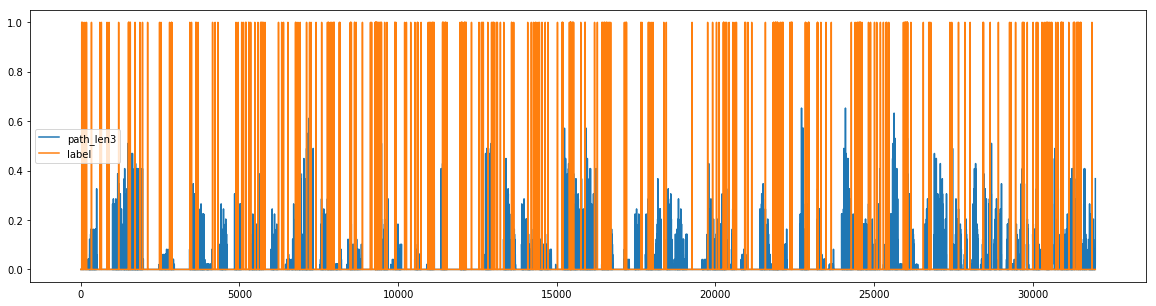

In [1464]:
train_data[2000].plot(y=['path_len3','label'],figsize=(20, 5))

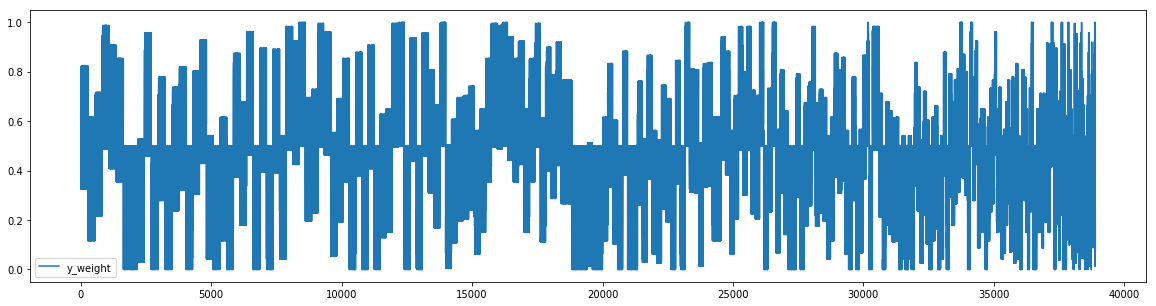

In [1408]:
train_data[2001][(train_data[2001]['label']==0)].plot(y=['y_weight'],figsize=(20, 5))

In [1455]:
train_data[2001][(train_data[2001]['label']==0)]

,row_name,label,aut,art,closeness,partition,y_weight,type,partition_cnt,path_len,path_len3
0,"(3074, 7176)",0,0.651432,0.504656,0.763593,0,0.441667,0.333333,0.078103,3,0.043478
1,"(3074, 8207)",0,0.658572,0.498761,0.770897,0,0.812500,0.583333,0.235022,18,0.260870
2,"(3074, 9240)",0,0.657002,0.510781,0.780194,0,0.783333,0.583333,0.335898,3,0.043478
3,"(3074, 7193)",0,0.345186,0.285281,0.370586,0,0.325000,0.208333,0.470400,0,0.000000
4,"(3074, 15388)",0,0.572408,0.285281,0.364343,0,0.325000,0.208333,0.470400,0,0.000000
5,"(3074, 16413)",0,0.515663,0.344218,0.605336,0,0.562500,0.583333,0.008526,0,0.000000
6,"(3074, 2079)",0,0.595100,0.415687,0.671600,0,0.645833,0.583333,0.098750,0,0.000000
7,"(3074, 1056)",0,0.592602,0.457379,0.749005,0,0.325000,0.333333,0.078103,3,0.043478
8,"(3074, 8225)",0,0.636515,0.494476,0.738220,0,0.629167,0.333333,0.026290,2,0.028986
9,"(3074, 11299)",0,0.647272,0.499160,0.765998,0,0.754167,0.583333,0.026290,9,0.130435
